In [1]:
import numpy as np
import pandas as pd
import os
import re
import datetime as dt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import BDay
from uuid import uuid4
import matplotlib.pyplot as plt
import pmdarima
import math
import itertools
# !pip install pmdarima

current_path = os.getcwd()
os.chdir(current_path)

'''
sic data retrieve lib import
-------------------
'''

'\nsic data retrieve lib import\n-------------------\n'

In [231]:
os.getcwd()

'/shared/Self_Insure'

In [9]:
os.chdir('/shared/Self_Insure/')

In [7]:
from falcon.loader import sic as sic_loader
from falcon.scenario_generators.SARIMA import SARIMA
from falcon.scenario_generators.main import generate_sim_dates as data_date
from falcon.scenario_generators.portfolio_tools import PortfolioTool
from falcon.scenario_generators.HistoricalSimulationV4 import HistoricalSimulation as HS

In [10]:
from HistoricalSimulation_platform import HistoricalSimulation as HS_p

In [11]:
def percentiles_as_dict(forecasts) -> dict:
    percentiles = {
        "min": np.min(forecasts, axis=1).tolist(),
        "5per": np.percentile(forecasts, 5, axis=1).tolist(),
        "10per": np.percentile(forecasts, 10, axis=1).tolist(),
        "20per": np.percentile(forecasts, 20, axis=1).tolist(),
        "30per": np.percentile(forecasts, 25, axis=1).tolist(),
        "40per": np.percentile(forecasts, 35, axis=1).tolist(),
        "50per": np.percentile(forecasts, 50, axis=1).tolist(),
        "60per": np.percentile(forecasts, 65, axis=1).tolist(),
        "70per": np.percentile(forecasts, 75, axis=1).tolist(),
        "80per": np.percentile(forecasts, 80, axis=1).tolist(),
        "90per": np.percentile(forecasts, 90, axis=1).tolist(),
        "95per": np.percentile(forecasts, 95, axis=1).tolist(),
        "max": np.max(forecasts, axis=1).tolist(),
        "mean": np.mean(forecasts, axis=1).tolist(),
        "std": np.std(forecasts, axis=1).tolist(),
    }
    return percentiles

In [12]:
def filtered_hs_bootstrap_seasonal(data, sic_str,freq,
         sim_length = 18, n_sims = 200):
    model = HS_p(filtering=True, bootstrap=True,weighting=f"S{freq}",reset_to_seed = int(sic_str[2:]))
    model.fit(data)
    forecasts = model.simulate(sim_length, num_paths=n_sims)
    percentiles = percentiles_as_dict(forecasts)
    # sort columns by mean: forecasts: n_sims x forecast_length
    # Compute the average of each column
    column_averages = np.mean(forecasts, axis=0)
    # Get the indices that would sort the columns based on their average
    sorted_indices = np.argsort(column_averages)
    # Sort the array columns based on the sorted indices
    forecasts = forecasts[:, sorted_indices]
    forecasts = forecasts.tolist()
    n_sims = len(forecasts[0])
    # create the return messages
    msg = {
        "generator_code_name": "filtered_hs_bootstrap_seasonal",
        "run_time": datetime.utcnow(),
        "raw_data": data,
        "sim_length": sim_length,
        "n_sims": n_sims,
        "status": "success",
        "forecast": forecasts,
        "percentiles": percentiles,
    }
    return msg

In [13]:
def hs_bootstrap_seasonal(data, sic_str,freq,
         sim_length = 18, n_sims = 200):
    model = HS_p(bootstrap=True, weighting=f"S{freq}",reset_to_seed = int(sic_str[2:]))
    model.fit(data)
    forecasts = model.simulate(sim_length, num_paths=n_sims)
    percentiles = percentiles_as_dict(forecasts)
    # sort columns by mean: forecasts: n_sims x forecast_length
    # Compute the average of each column
    column_averages = np.mean(forecasts, axis=0)
    # Get the indices that would sort the columns based on their average
    sorted_indices = np.argsort(column_averages)
    # Sort the array columns based on the sorted indices
    forecasts = forecasts[:, sorted_indices]
    forecasts = forecasts.tolist()
    n_sims = len(forecasts[0])
    # create the return messages
    msg = {
        "generator_code_name": "hs_bootstrap_seasonal",
        "run_time": datetime.now(),
        "raw_data": data,
        "sim_length": sim_length,
        "n_sims": n_sims,
        "status": "success",
        "forecast": forecasts,
        "percentiles": percentiles,
    }
    return msg

In [14]:
import statsmodels
def sarima(data, order,
           sim_length = 18, n_sims = 200):
    # run the sarima model
    # order: [p, d, q, P, D, Q, s] where s is the seasonal period

    # model fitting
    AR, D, MA, SAR, SD, SMA, SS = order
    model = statsmodels.api.tsa.statespace.SARIMAX(data, trend='c', order=(AR, D, MA), seasonal_order=(SAR, SD, SMA, SS))
    sarima_res = model.fit(disp=0)
    forecasts = np.array(
        [sarima_res.simulate(sim_length, anchor='end') for x in range(n_sims)]).T
    percentiles = percentiles_as_dict(forecasts)
    # sort columns by mean: forecasts: n_sims x forecast_length
    # Compute the average of each column
    column_averages = np.mean(forecasts, axis=0)
    # Get the indices that would sort the columns based on their average
    sorted_indices = np.argsort(column_averages)
    # Sort the array columns based on the sorted indices
    forecasts = forecasts[:, sorted_indices]
    forecasts = forecasts.tolist()

    # save results
    msg = {"generator_code_name": "sarima", "run_time": datetime.utcnow(), "raw_data": data, "sim_length": sim_length,
           "n_sims": n_sims, "status": "success", "stats_tests": {
            'AIC_BIC_HQIC': sarima_res.aic + sarima_res.bic + sarima_res.hqic,
            'AIC_BIC': sarima_res.aic + sarima_res.bic,
            'HQIC': sarima_res.hqic,
            'std_resid': np.nanstd(sarima_res.resid),
            'sarima_summary': sarima_res.summary().as_text(),
        }, "model_parameters": {
            "AR": AR,
            "D": D,
            "MA": MA,
            "SAR": SAR,
            "SD": SD,
            "SMA": SMA,
            "SS": SS,
        },
           'forecast': forecasts,
           'percentiles': percentiles,
           }
    return msg

In [72]:
def get_sic(sic_str,datetime_start = '2011-01-01',datetime_end = '2024-11-01'):
    frequency = 'M'
    datetime_anchor = pd.to_datetime(datetime_end)
    details, sic_data, _ = sic_loader.DataCenter.load_sic_data_db(sic_str, drop_extension=False)
    sic_data = sic_data[sic_data.index < datetime_anchor]
    sic_data = sic_data[sic_data.index >= pd.to_datetime(datetime_start)]
    sic_data = sic_data.resample('MS').mean()
    sic_data = np.exp(np.log(sic_data).interpolate())
    return sic_data

In [812]:
# get all fhsb simulations 
for sic_str in ['US4353','US3604','US614','US94','US3356','US452']:
    for i in tqdm(range(1,61)):
        date_ = pd.date_range('2018-10-01', '2023-09-01', freq='MS')[-i]  # selling month
        sic_data = get_sic(sic_str,datetime_start = '2011-01-01',datetime_end = date_)
        file_name = 'paths/' + str(sic_str) + '_' + str(date_)[:10] + '_FHSB.pkl'
        try:
            msg = pd.read_pickle(file_name)       
        except:
            msg = filtered_hs_bootstrap_seasonal(sic_data, sic_str ,freq=12,sim_length = 15,n_sims = 10000)
            msg = pd.DataFrame([msg])
            msg.to_pickle(file_name) 

100%|██████████| 60/60 [01:56<00:00,  1.94s/it]


In [813]:
# get all sarima simulations 
for sic_str in ['US4353','US3604','US614','US94','US3356','US452']:
    for i in tqdm(range(1,61)):
        date_ = pd.date_range('2018-10-01', '2023-09-01', freq='MS')[-i]  # selling month
        sic_data = get_sic(sic_str,datetime_start = '2011-01-01',datetime_end = date_)
        file_name = 'paths/' + str(sic_str) + '_' + str(date_)[:10] + '_SARIMA.pkl'
        try:
            msg = pd.read_pickle(file_name)       
        except:
            model = pmdarima.auto_arima(sic_data, d = 1, information_criterion = 'bic',stepwise = True,
                          start_p = 0,max_p = 5,max_d = 1,
                          start_q = 0,max_q = 5, 
                          start_P = 0,max_P = 2,start_Q = 0,max_Q = 2, max_order = 5,
                          seasonal=True, m=12)
            sarima_params = [model.order[0], model.order[1], model.order[2], 
                    model.seasonal_order[0], model.seasonal_order[1], model.seasonal_order[2], 12]
            msg = sarima(sic_data, order=sarima_params,sim_length = 18,n_sims = 10000)
            msg = pd.DataFrame([msg])
            msg.to_pickle(file_name) 

100%|██████████| 60/60 [01:56<00:00,  1.95s/it]


In [1112]:
def calc_configs (msg, increment,D_lowerbound,spread_upperbound,rol_target,delay = 1):
    res = {}
    for d,sp in itertools.product(range(D_lowerbound, 100, 1), range(1,spread_upperbound,1)):
        spread = increment * (0+sp)
        D = increment * d
        Stable_payoff = []
        strike = []
        for i in range(0+delay,12+delay):
            ret = ret_list[i % 12]
            Stable_strike = [ret * x + D for x in msg['forecast'][i-1]]
            Stable_limit = [x + spread for x in Stable_strike]
            Stable_settlement = msg['forecast'][i]
            payoff = [min(spread, max(0,x-y)) for x,y in zip(Stable_settlement,Stable_strike)]
            Stable_payoff.append(payoff)
            strike.append(np.mean(Stable_strike))
        ROL = np.mean(Stable_payoff)/spread
        
        if ROL < rol_target:

            res = { 'd_inc' : d,
                    'sp_inc' : sp,
                    'D':D,
                    'spread':spread,
                    'strike':strike,
                    'limit':[x+spread for x in strike],
                    'premium':12 * np.mean(Stable_payoff),
                    'ROL':ROL}
            break       
    return res

In [1122]:
# get current stats
sic_str = 'US452'
sic_data = get_sic(sic_str,datetime_start = '2011-01-01',datetime_end = '2024-11-01')
latest_price = np.array(sic_data.iloc[-1])[0]
sic_ret = sic_data/sic_data.shift(1)
D_lowerbound = int(math.ceil(0.7*np.std(sic_ret[-36:],axis = 0).iloc[0]/0.01))
spread_upperbound = int(math.ceil(1.5*np.std(sic_ret[-36:],axis = 0).iloc[0]/0.01))
indices = np.array([-1, -13, -25, -37, -49, -61, -73])
ret_list = [sic_ret.iloc[indices - i].mean().values[0] for i in range(12)]
ret_list.reverse()
sg = calc_vol (sic_str,date_ = '2024-11-01')
file_name = 'paths/'+str(sic_str)+'_2024-11-01_'+str(sg)+'.pkl'  
try:
    msg = pd.read_pickle(file_name)       
except:
    if sg == 'HSBS':
        msg = hs_bootstrap_seasonal(sic_data, sic_str ,freq=12,sim_length = 15,n_sims = 10000)
    elif sg == 'FHSB':
        msg = filtered_hs_bootstrap_seasonal(sic_data, sic_str ,freq=12,sim_length = 15,n_sims = 10000)
    elif sg == 'SARIMA':
        model = pmdarima.auto_arima(sic_data, d = 1, information_criterion = 'bic',stepwise = True,
                          start_p = 0,max_p = 5,max_d = 1,
                          start_q = 0,max_q = 5, 
                          start_P = 0,max_P = 2,start_Q = 0,max_Q = 2, max_order = 5,
                          seasonal=True, m=12)
        sarima_params = [model.order[0], model.order[1], model.order[2], 
                    model.seasonal_order[0], model.seasonal_order[1], model.seasonal_order[2], 12]
        msg = sarima(sic_data, order=sarima_params,sim_length = 15,n_sims = 10000)
    msg = pd.DataFrame([msg])
    msg.to_pickle(file_name) 
msg = msg.to_dict(orient='records')[0]
try:
    res = calc_configs (msg, round(latest_price*0.01,2),D_lowerbound,spread_upperbound,rol_target = 0.035,delay = 1)
except:
    res = calc_configs (msg, round(latest_price*0.01,2),D_lowerbound,spread_upperbound = 100,rol_target = 0.035,delay = 1)

SAF = []
for i in range(1,13):
    ret = ret_list[i % 12]
    SAF.append(ret)
D_ratio = res['D'] / latest_price
spread_ratio = res['spread']/ latest_price
strike_ratio = [x+D_ratio for x in SAF]
premium_ratio = res['premium']/12/latest_price

In [1123]:
from scipy.stats import percentileofscore
from concurrent.futures import ProcessPoolExecutor
from time import sleep
from tqdm import tqdm
import pickle
import csv

# get all backtesting stats
sic_str = 'US452'
result = {}
delay = 1
# Define a function to process a single date
def process_date(i):
    try:
        date_ = pd.date_range('2018-10-01', '2023-09-01', freq='MS')[-i]  # selling month
        sic_data = get_sic(sic_str, datetime_start='2011-01-01', datetime_end=date_)
        latest_price = np.array(sic_data.iloc[-1])[0]
        sic_ret = sic_data/sic_data.shift(1)
        D_lowerbound = int(math.ceil(0.7*np.std(sic_ret[-36:],axis = 0).iloc[0]/0.01))
        spread_upperbound = int(math.ceil(1.5*np.std(sic_ret[-36:],axis = 0).iloc[0]/0.01))
        indices = np.array([-1, -13, -25, -37, -49, -61, -73])
        ret_list = [sic_ret.iloc[indices - i].mean().values[0] for i in range(12)]
        ret_list.reverse()

        vol = np.std(sic_ret[-36:],axis = 0).iloc[0]
        sg = calc_vol (sic_str,date_)
        
        file_name = 'paths/' + str(sic_str) + '_' + str(date_)[:10] + '_'+str(sg)+'.pkl'
        try:
            msg = pd.read_pickle(file_name)
        except:
            msg = hs_bootstrap_seasonal(sic_data, sic_str, freq=12, sim_length=15, n_sims=10000)
            msg = pd.DataFrame([msg])
            msg.to_pickle(file_name)
        msg = msg.to_dict(orient='records')[0]

        try:
            res = calc_configs (msg, round(latest_price*0.01,2),D_lowerbound,spread_upperbound,rol_target = 0.035,delay = 1)
        except:
            res = calc_configs (msg, round(latest_price*0.01,2),D_lowerbound,spread_upperbound = 100,rol_target = 0.035,delay = 1)
            
        res['vol'] = vol
        res['latest_price'] = latest_price
        res['D_lowerbound'] = D_lowerbound
        res['spread_upperbound'] = spread_upperbound
        res['SG_selected'] = sg
         # Debugging: Check if 'strike' exists
        if 'strike' not in res:
            raise ValueError(f"'strike' is missing in res: {res}")
        
        settlement_data = get_sic(sic_str, datetime_start=date_, datetime_end='2024-12-01')
        settlement = list(settlement_data[sic_str])[0+delay:12+delay]
    
        # dynamic
        fixation = list(settlement_data[sic_str])[0+delay-1:12+delay-1]
        SAF = []
        D = res['D']
        for i in range(0+delay,12+delay):
            ret = ret_list[i % 12]
            SAF.append(ret)
        strike = [x * y + D for x,y in zip(fixation,SAF)] # [0] in fixation times [2] in ret_list = [0] in strike
                  
        spread = res['spread']
        payoff = [min(spread, max(0, x - y)) for x, y in zip(settlement, strike)]
        LR = np.sum(payoff) / res['premium']
        res['dynamic_strike'] = strike
        res['dynamic_limit'] = [x + spread for x in strike]
        res['dynamic_payoff'] = payoff
        res['dynamic_lr'] = LR

        sg_list = ['HSBS','FHSB','SARIMA']
        sg_list.remove(sg)
        for model in sg_list:
            msg_new = pd.read_pickle('paths/' + str(sic_str) + '_' + str(date_)[:10] + '_'+str(model)+'.pkl')
            msg_new = msg_new.to_dict(orient='records')[0]
            Stable_payoff = []
            for i in range(0+delay,12+delay):
                ret = ret_list[i % 12]
                Stable_strike = [ret * x + D for x in msg_new['forecast'][i-1]]
                Stable_limit = [x + spread for x in Stable_strike]
                Stable_settlement = msg_new['forecast'][i]
                payoff = [min(spread, max(0,x-y)) for x,y in zip(Stable_settlement,Stable_strike)]
                Stable_payoff.append(payoff)
            premium = np.mean(Stable_payoff)
            res[str(model)] = 12*premium
        '''
        # get percentile of strikes
        percentile_loc = []
        for i in range (0,12):
            simulation = msg['forecast'][i+delay]
            strike_to_test = strike[i]
            perc = percentileofscore(simulation, strike_to_test)
            percentile_loc.append(round(perc))
        res['strike_percentile'] = percentile_loc
        '''
        # static
        static_strike = [x * y for x,y in zip(fixation,strike_ratio)]
        static_spread = res['spread']
        static_limit = [x + static_spread for x in static_strike]
        static_premium = [x * premium_ratio for x in fixation ]
        static_payoff = [min(static_spread, max(0,x-y)) for x,y in zip(settlement, static_strike)]
        static_LR = np.sum(static_payoff) / np.sum(static_premium)
        res['fixation'] = fixation
        res['static_strike'] = static_strike
        res['static_limit'] = static_limit
        res['static_spread'] = static_spread
        res['static_premium'] = np.sum(static_premium)
        res['static_payoff'] = static_payoff
        res['static_lr'] = static_LR
        
        return str(date_)[:10], res
    except Exception as e:
        print(f"Error processing date {i}: {e}")
        raise
# Use ProcessPoolExecutor to parallelize the loop
with ProcessPoolExecutor() as executor:
    futures = list(tqdm(executor.map(process_date, range(1, 61)), total=60))

# Collect results into the result dictionary
result = dict(futures)


100%|██████████| 60/60 [00:54<00:00,  1.11it/s]


In [1124]:
# Create a CSV file to write the data
with open('output_US452.csv', mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header row
    header = ['date','spot','vol','D', 'spread','dynamic_lr', 'ROL','sg selected','premium','sg_2','premium_2','sg_3','premium_3']
    writer.writerow(header)
    
    # Iterate over each key in the result dictionary
    for key, data in result.items():
        # Extract values for the current key
        vol = data['vol']
        spot = data['latest_price']
        D = data['D']
        spread = round(data['spread'], 2)
        sg_selected = data['SG_selected']
        dynamic_lr = data['dynamic_lr']
        ROL = data['ROL']
        premium = data['premium']/12
        sg_list = ['HSBS','FHSB','SARIMA']
        sg_list.remove(sg_selected)
        sg_2 = sg_list[0]
        premium_2 = data[sg_2]/12
        sg_3 = sg_list[1]
        premium_3 = data[sg_3]/12
        
        
        row = [key, spot,vol,D, spread,dynamic_lr, ROL,sg_selected,premium,sg_2,premium_2,sg_3,premium_3]
        writer.writerow(row)

print("CSV file 'output.csv' has been created.")

CSV file 'output.csv' has been created.


In [1125]:
# save result
result = pd.DataFrame([result])
result.to_pickle('RRG_rolling/'+sic_str+'_result_35.pkl') 
result = result.to_dict(orient='records')[0]

In [1200]:
# read result
result = pd.read_pickle('RRG_rolling/US94'+'_result_35.pkl') 
result = result.to_dict(orient='records')[0]

In [229]:
def calc_spread_mean (result):
    spread_ratio_list= []
    for key in result.keys():
        a = result[key]['fixation']
        b = result[key]['spread']
        spread_ratio = b/a
        spread_ratio_list.append(spread_ratio)
    return np.mean(spread_ratio_list)
calc_spread_mean(result)

In [37]:
def calculate_ratios(payoff, spread):
    ratios = []
    for num in payoff:
        if num == spread or num == 0:
            ratio = num / spread
            ratios.append(ratio)          
        else:
            ratios.append(-1)
    return ratios

In [38]:
def calc_cumulative_lr (premium,payoff):
    # Initialize arrays to hold cumulative sums
    cumulative_premium = np.zeros(len(premium))
    cumulative_payoff = np.zeros(len(payoff))
    
    # Compute cumulative sums
    cumulative_premium[0] = premium[0]
    cumulative_payoff[0] = payoff[0]
    
    for i in range(1, len(premium)):
        cumulative_premium[i] = cumulative_premium[i-1] + premium[i]
        cumulative_payoff[i] = cumulative_payoff[i-1] + payoff[i]
    
    # Calculate the cumulative loss ratio
    cumulative_loss_ratio = cumulative_payoff / cumulative_premium
    return cumulative_loss_ratio

In [1201]:
# calculate payoff percentage
dynamic_ratios_all = []
static_ratios_all = []
for key in result.keys():
    a = result[key]['dynamic_payoff']
    b = result[key]['static_payoff']
    dynamic_spread = result[key]['spread']
    static_spread = result[key]['static_spread']
    dynamic_ratios = calculate_ratios(a, dynamic_spread)
    static_ratios = calculate_ratios(b, static_spread)
    dynamic_ratios_all.append(dynamic_ratios)
    static_ratios_all.append(static_ratios)
dynamic_ratios_all = [item for sublist in dynamic_ratios_all for item in sublist]
static_ratios_all = [item for sublist in static_ratios_all for item in sublist]
dynamic_nonzero_payout = 1 - dynamic_ratios_all.count(0) / 720
dynamic_full_payout = dynamic_ratios_all.count(1) / 720
static_nonzero_payout = 1 - static_ratios_all.count(0) / 720
static_full_payout = static_ratios_all.count(1) / 720
print (dynamic_nonzero_payout,dynamic_full_payout,
      static_nonzero_payout,static_full_payout
      )

0.10138888888888886 0.04861111111111111 0.10138888888888886 0.06111111111111111


In [1202]:
# prepare payoff list for plotting & get cum LR
dynamic_payoff = []
static_payoff = []
dynamic_premium = []
static_premium = []

for key in result.keys():
    a = np.sum(result[key]['static_payoff'])   
    b = np.sum(result[key]['dynamic_payoff']) 
    c = np.mean(result[key]['static_premium'])   
    d = np.mean(result[key]['premium']) 
    static_payoff.append(a)
    dynamic_payoff.append(b)
    static_premium.append(c)
    dynamic_premium.append(d)
    
static_payoff.reverse()
dynamic_payoff.reverse()
static_premium.reverse()
dynamic_premium.reverse()
dynamic_cumulative_loss_ratio =  calc_cumulative_lr (dynamic_premium,dynamic_payoff)
static_cumulative_loss_ratio =  calc_cumulative_lr (static_premium,static_payoff)
print (dynamic_cumulative_loss_ratio[-1],static_cumulative_loss_ratio[-1]
      )

1.1024919819585042 1.9804439852209232


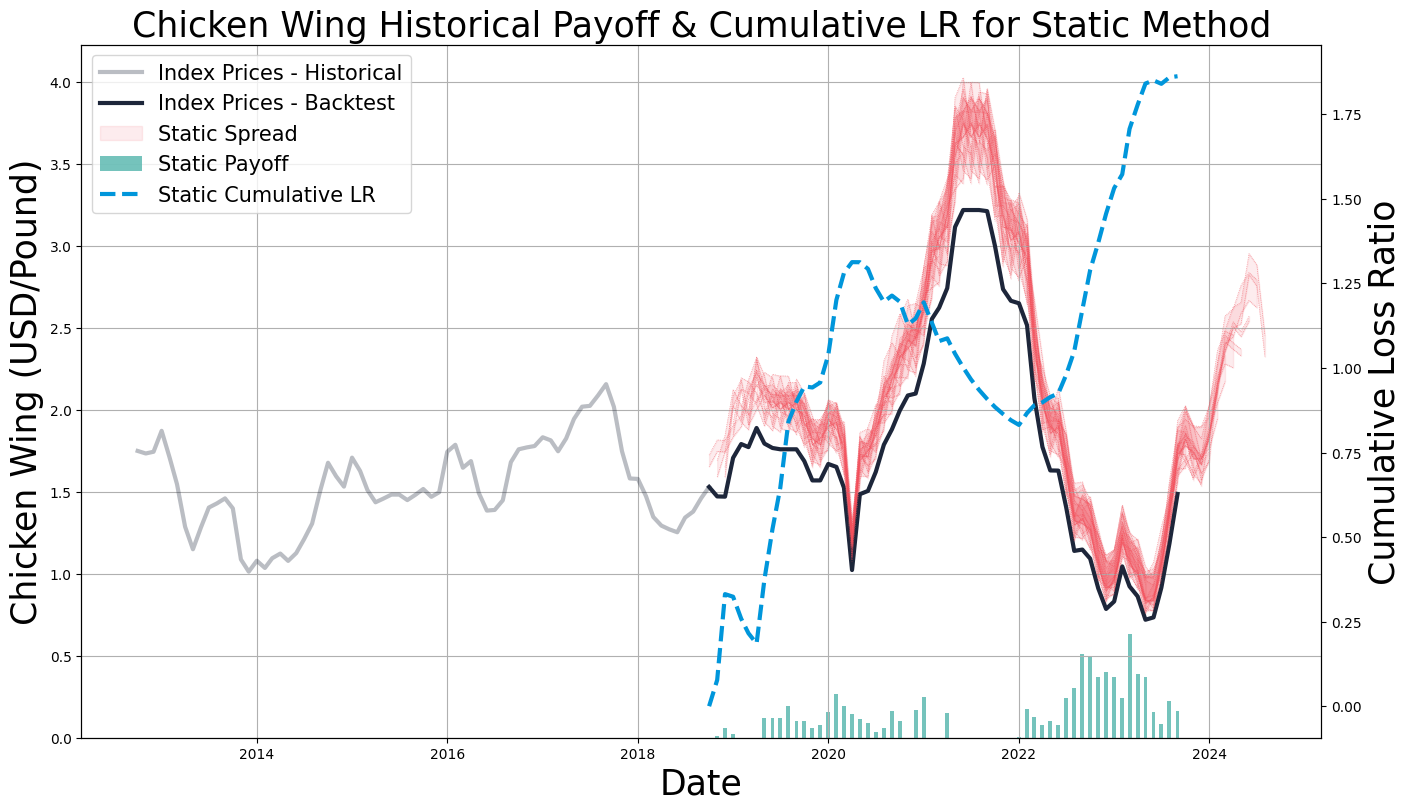

In [711]:
# plot static only 
sic_str = 'US452'
sic_data1 = get_sic(sic_str,datetime_start = '2012-10-01',datetime_end = '2018-11-01')
sic_date_range1 = pd.date_range(start='2012-10-01', periods=73, freq='MS')
sic_data2 = get_sic(sic_str,datetime_start = '2018-10-01',datetime_end = '2023-10-01')
sic_date_range2 = pd.date_range(start='2018-10-01', periods=60, freq='MS')
bt_date_range = pd.date_range(start='2018-10-01', periods=60, freq='MS')
fig, ax1 = plt.subplots(figsize=(16, 9))
ax1.plot(sic_date_range1,list(sic_data1[sic_str]),label='Index Prices - Historical', linewidth = 3, color='#1D263A',alpha = 0.3)
ax1.plot(sic_date_range2,list(sic_data2[sic_str]),label='Index Prices - Backtest', linewidth = 3, color='#1D263A')
for i in range(0,60,1):
    this_time = sic_date_range2[i]
    contract_date_range = pd.date_range(start=this_time, periods=12, freq='MS')
    dynamic_strike = result[str(this_time)[:10]]['dynamic_strike']
    dynamic_limit = result[str(this_time)[:10]]['dynamic_limit']
    static_strike = result[str(this_time)[:10]]['static_strike']
    static_limit = result[str(this_time)[:10]]['static_limit']
    if i == 0:
        ax1.plot(contract_date_range,static_strike,':',linewidth = 0.5,color='#F24D59',alpha = 0.7)
        ax1.plot(contract_date_range,static_limit,':',linewidth = 0.5,color='#F24D59',alpha = 0.7)
        ax1.fill_between(contract_date_range,static_limit,static_strike,label='Static Spread',alpha = 0.1, color = '#F24D59' )
    else:
        #ax1.plot(contract_date_range,dynamic_strike,':',linewidth = 0.5,color='red',alpha = 1)
        #ax1.plot(contract_date_range,dynamic_limit,':',linewidth = 0.5,color='red',alpha = 1)
        #ax1.fill_between(contract_date_range,dynamic_limit,dynamic_strike,alpha = 0.1, color = '#F24D59' )
        ax1.plot(contract_date_range,static_strike,':',linewidth = 0.5,color='#F24D59',alpha = 0.7)
        ax1.plot(contract_date_range,static_limit,':',linewidth = 0.5,color='#F24D59',alpha = 0.7)
        ax1.fill_between(contract_date_range,static_limit,static_strike,alpha = 0.1, color = '#F24D59' )

ax1.bar(bt_date_range,static_payoff,label='Static Payoff', width=15, color='#53B5AC',alpha = 0.8)
#ax1.bar(bt_date_range,dynamic_payoff, label='Dynamic Payoff', width=15, color='#1D263A',alpha = 0.5)
ax1.grid()
ax1.set_xlabel("Date",fontsize = 25)
ax1.set_ylabel("Chicken Wing (USD/Pound)",fontsize = 25)
ax1.set_title('Chicken Wing Historical Payoff & Cumulative LR for Static Method',fontsize = 25)
ax2 = ax1.twinx()
ax2.plot(bt_date_range, static_cumulative_loss_ratio,'--',label = 'Static Cumulative LR',color = '#0096DB',linewidth = '3')
#ax2.plot(bt_date_range, dynamic_cumulative_loss_ratio,'--',label = 'Dynamic Cumulative LR',color = '#F24D59',linewidth = '3')
ax2.set_ylabel('Cumulative Loss Ratio',fontsize = 25)

handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles.extend(handles2)
labels.extend(labels2)
plt.legend(handles=handles, labels=labels, loc="upper left", fontsize=15)
# plt.show()
plt.savefig(f'{sic_str} static backtesting - rolling.png',transparent=True)


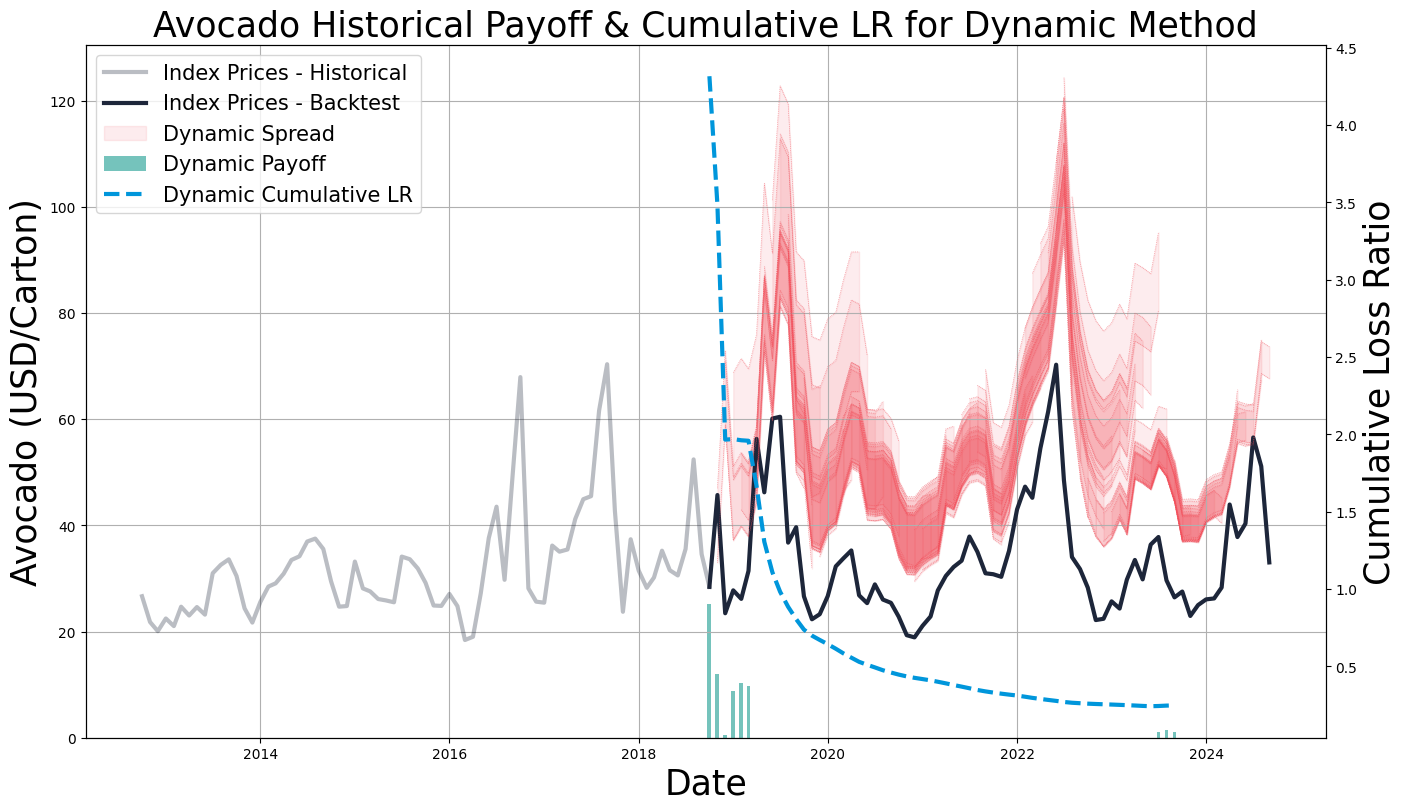

In [1199]:
# plot dynamic only 
sic_str = 'US3356'
sic_data1 = get_sic(sic_str,datetime_start = '2012-10-01',datetime_end = '2018-11-01')
sic_date_range1 = pd.date_range(start='2012-10-01', periods=73, freq='MS')
sic_data2 = get_sic(sic_str,datetime_start = '2018-10-01',datetime_end = '2024-10-01')
sic_date_range2 = pd.date_range(start='2018-10-01', periods=72, freq='MS')
sic_date_range3 = pd.date_range(start='2018-11-01', periods=60, freq='MS')
bt_date_range = pd.date_range(start='2018-10-01', periods=60, freq='MS')
fig, ax1 = plt.subplots(figsize=(16, 9))
ax1.plot(sic_date_range1,list(sic_data1[sic_str]),label='Index Prices - Historical', linewidth = 3, color='#1D263A',alpha = 0.3)
ax1.plot(sic_date_range2,list(sic_data2[sic_str]),label='Index Prices - Backtest', linewidth = 3, color='#1D263A')

for i in range(0,60,1):
    this_time = sic_date_range2[i]
    this_time_next = sic_date_range3[i]
    contract_date_range = pd.date_range(start=this_time_next, periods=12, freq='MS')
    dynamic_strike = result[str(this_time)[:10]]['dynamic_strike']
    dynamic_limit = result[str(this_time)[:10]]['dynamic_limit']
    static_strike = result[str(this_time)[:10]]['static_strike']
    static_limit = result[str(this_time)[:10]]['static_limit']
    if i == 0:
        ax1.plot(contract_date_range,dynamic_strike,':',linewidth = 0.5,color='#F24D59',alpha = 0.7)
        ax1.plot(contract_date_range,dynamic_limit,':',linewidth = 0.5,color='#F24D59',alpha = 0.7)
        ax1.fill_between(contract_date_range,dynamic_limit,dynamic_strike,label='Dynamic Spread',alpha = 0.1, color = '#F24D59' )
    else:
        #ax1.plot(contract_date_range,dynamic_strike,':',linewidth = 0.5,color='red',alpha = 1)
        #ax1.plot(contract_date_range,dynamic_limit,':',linewidth = 0.5,color='red',alpha = 1)
        #ax1.fill_between(contract_date_range,dynamic_limit,dynamic_strike,alpha = 0.1, color = '#F24D59' )
        ax1.plot(contract_date_range,dynamic_strike,':',linewidth = 0.5,color='#F24D59',alpha = 0.7)
        ax1.plot(contract_date_range,dynamic_limit,':',linewidth = 0.5,color='#F24D59',alpha = 0.7)
        ax1.fill_between(contract_date_range,dynamic_limit,dynamic_strike,alpha = 0.1, color = '#F24D59' )

ax1.bar(bt_date_range,dynamic_payoff,label='Dynamic Payoff', width=15, color='#53B5AC',alpha = 0.8)
#ax1.bar(bt_date_range,dynamic_payoff, label='Dynamic Payoff', width=15, color='#1D263A',alpha = 0.5)
ax1.grid()
ax1.set_xlabel("Date",fontsize = 25)
ax1.set_ylabel("Avocado (USD/Carton)",fontsize = 25)
ax1.set_title('Avocado Historical Payoff & Cumulative LR for Dynamic Method',fontsize = 25)
ax2 = ax1.twinx()
ax2.plot(bt_date_range, dynamic_cumulative_loss_ratio,'--',label = 'Dynamic Cumulative LR',color = '#0096DB',linewidth = '3')
ax2.set_ylabel('Cumulative Loss Ratio',fontsize = 25)

handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles.extend(handles2)
labels.extend(labels2)
plt.legend(handles=handles, labels=labels, loc="upper left", fontsize=15)
# plt.show()
plt.savefig(f'{sic_str} dynamic backtesting-rolling.png',transparent=True)


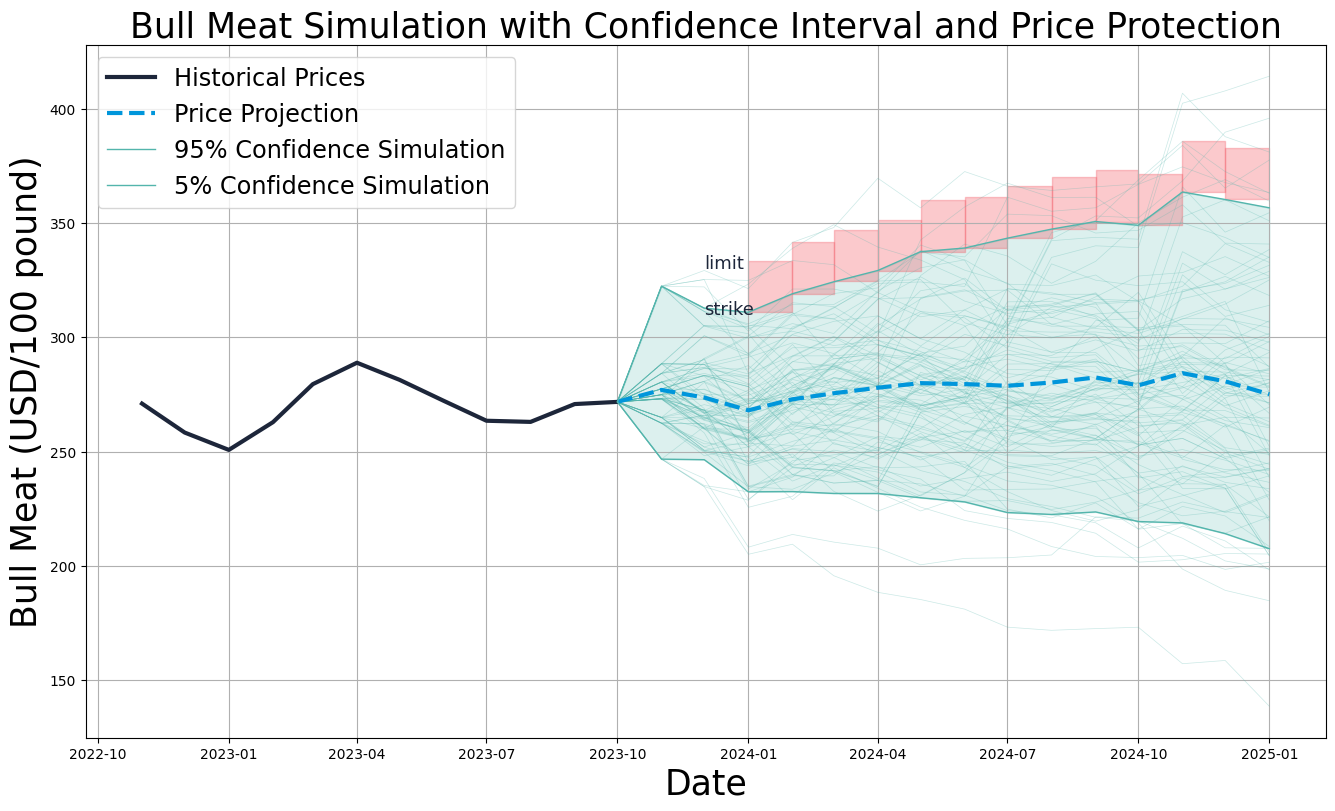

In [606]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

sic_str = 'US4353'
sic_data = get_sic(sic_str,datetime_start = '2012-01-01',datetime_end = '2023-11-01')
latest_price = np.array(sic_data.iloc[-1])[0]
file_name = 'paths/'+str(sic_str)+'_2023-11-01_HSBS.pkl'    
try:
    msg = pd.read_pickle(file_name)       
except:
    msg = hs_bootstrap_seasonal(sic_data, sic_str ,freq=12,sim_length = 15,n_sims = 10000)
    msg = pd.DataFrame([msg])
    msg.to_pickle(file_name) 
msg = msg.to_dict(orient='records')[0]
res = calc_configs (msg, 2.5)

date_range_historical = pd.date_range(start='2022-11-01', end='2023-10-31', freq='MS')
msg['raw_data'] = msg['raw_data'][msg['raw_data'].index <= '2023-10-31']
msg['raw_data'] = msg['raw_data'][msg['raw_data'].index >= '2022-11-01']
price_data_historical = list(msg['raw_data'][sic_str])  
df_historical = pd.DataFrame({'Date': date_range_historical, 'Price': price_data_historical})
future_price_lists = msg['forecast'] 

# Generate date range for future months from Oct 23 to Jan 24 (16 months)
date_range_future = pd.date_range(start='2023-10-01', periods=16, freq='MS')
# Generate date range for future months from Jan 24 to Dec 24 (14 months)
date_range_deal = pd.date_range(start='2024-01-01', periods=12, freq='MS')
date_range_box = pd.date_range(start='2024-01-01', periods=13, freq='MS')
last_point = msg['raw_data'].iloc[-1,0]

# Plot
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(df_historical['Date'], df_historical['Price'], label='Historical Prices', linewidth = 3, color='#1D263A')

# Plot the paths formed by each sequence of prices across the months
for i in range(0,10000,100):  # Iterate over each price position
    path_prices = [last_point] + [future_price_lists[j][i] for j in range(0,15)]  # Get the i-th price across all months
    plt.plot(date_range_future, path_prices, color='#53B5AC', alpha=0.3, linewidth=0.5)
plt.plot(date_range_future, [last_point]+msg['percentiles']['mean'],'--',label = 'Price Projection',color = '#0096DB',linewidth = '3')

plt.legend()
plt.grid()
plt.xlabel("Date",fontsize = 25)
plt.ylabel("Bull Meat (USD/100 pound)",fontsize = 25)
plt.title('Bull Meat Simulation with Confidence Interval and Price Protection',fontsize = 25)

ax.plot(date_range_future,[last_point]+msg['percentiles']['95per'], label="95% Confidence Simulation",linewidth = 1,color = '#53B5AC')
ax.plot(date_range_future,[last_point]+msg['percentiles']['5per'], label="5% Confidence Simulation",linewidth = 1,color = '#53B5AC')
ax.fill_between(date_range_future,[last_point]+msg['percentiles']['95per'], [last_point]+msg['percentiles']['5per'],alpha = 0.2, color = '#53B5AC' )

# ax.plot(date_range_deal,strike, label="strike price",linewidth = 2)
# ax.plot(date_range_deal,limit, label="limit price",linewidth = 2)
strike = res['strike']
limit = res['limit']
# Fill square boxes between the two lines
for i in range(0,len(date_range_deal)):
    height = limit[i] - strike[i]  # Height of the box based on the difference
    plt.fill_between([date_range_box[i], date_range_box[i+1]],
                     [strike[i], strike[i]], [limit[i], limit[i]], 
                     color='#F24D59', alpha=0.3)

plt.text(pd.to_datetime('2023-12-01'), 330, 'limit', fontsize=13, color='#1D263A')
plt.text(pd.to_datetime('2023-12-01'), 310, 'strike', fontsize=13, color='#1D263A')

ax.legend(loc='best',fontsize = 'xx-large')

# Display the plot
plt.savefig(f'{sic_str} forecast.png',transparent=True)

In [222]:
strike

[40.1, 43.8, 54.9, 57.1, 64.1, 73.7, 77.1, 78.9, 77.2, 68.8, 71.0, 79.9]

In [221]:
sic_data[-11:]

,US3356
date,
2024-01-31,26.071429
2024-02-29,26.250000
2024-03-31,28.312500
2024-04-30,43.950000
2024-05-31,37.818182
2024-06-30,40.357143
2024-07-31,56.583333
2024-08-31,51.147727
2024-09-30,33.039474
